# Question 2

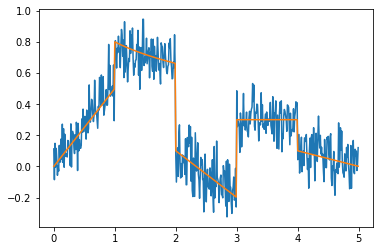

In [1]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg as sparselinalg
from scipy.sparse import spdiags
import matplotlib.pyplot as plt
x = np.arange(0,5, 0.01)
n = np.size(x)
one = int(n / 5)
f = np.zeros(x.shape)
f[0:one] = 0.0 + 0.5*x[0:one]
f[(one):2*one] = 0.8 - 0.2*np.log(x[100:200]);
f[(2*one):3*one] = 0.7 - 0.3*x[(2*one):3*one];
f[(3*one):4*one] = 0.3
f[(4*one):(5*one)] = 0.5 - 0.1*x[(4*one):(5*one)];
G = spdiags([-np.ones(n), np.ones(n)], np.array([0, 1]), n-1,n)
etta = 0.1*np.random.randn(np.size(x));
y = f + etta
plt.figure(); plt.plot(x,y); plt.plot(x,f); plt.show()

## Section A

In [2]:
reg_factor = 80
res1 = sparselinalg.inv(scipy.sparse.eye(n)+(reg_factor/2)*G.transpose()@G)@y

C:\Users\paney\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\paney\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


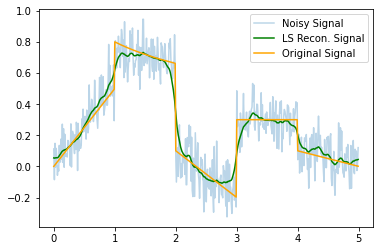

In [3]:
plt.figure();plt.plot(x,y,label="Noisy Signal", alpha=0.3); plt.plot(x,res1,label="LS Recon. Signal", color="green"); plt.plot(x,f,label="Original Signal", color="orange"); plt.legend(); plt.show()

## Section B

In [4]:
reg_factor = 1
epsilon = 0.001
num_iterations = 10
W = scipy.sparse.eye(n-1)

In [5]:
for i in range(num_iterations):
    res2 = sparselinalg.inv(scipy.sparse.eye(n) + reg_factor*G.transpose()@W@G)@y
    W = scipy.sparse.diags(1/(abs(G@res2) + epsilon))

C:\Users\paney\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\paney\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
C:\Users\paney\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\paney\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
C:\Users\paney\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu r

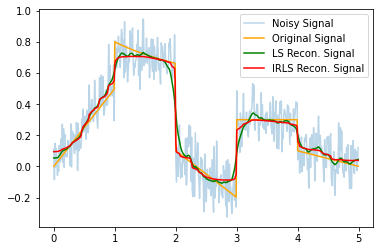

In [6]:
plt.figure();plt.plot(x,y,label="Noisy Signal", alpha=0.3); plt.plot(x,f,label="Original Signal", color="orange"); plt.plot(x,res1,label="LS Recon. Signal", color="green");  plt.plot(x,res2,label="IRLS Recon. Signal", color="red"); plt.legend(); plt.show()

# Question 3

## Section E

In [7]:
with open(r'Covid-19-USA.txt', 'r') as f:
    data = np.array([l.strip() for l in f.read().splitlines()], dtype=np.int32)

In [8]:
data

array([     1,      1,      1,      1,      2,      2,      5,      5,
            5,      5,      6,      7,      8,     11,     11,     11,
           12,     12,     12,     12,     12,     13,     13,     14,
           15,     15,     15,     15,     15,     15,     15,     16,
           35,     35,     35,     53,     53,     59,     60,     66,
           69,     89,    103,    125,    159,    233,    338,    433,
          554,    754,   1025,   1312,   1663,   2174,   2951,   3774,
         4661,   6427,   9415,  14250,  19624,  26747,  35206,  46442,
        55231,  69194,  85991, 104686, 124665, 143025, 164620, 189618,
       216721, 245540, 277965, 312237, 337635, 368196, 398809, 432132,
       466033, 501560, 529951, 557571, 582594, 609516, 639664, 671331,
       702164, 735086, 759687, 787752, 825041, 842629, 869172, 890524,
       939053, 965910, 988451])

In [9]:
X = np.array(range(1, 100))

In [10]:
def model(t1, t2, t3):
    return t1*np.exp(-t2*((X-t3)**2))

def F(t1, t2, t3):
    pred = model(t1, t2, t3)
    return 0.5*((pred-data)@(pred-data))

In [11]:
init_theta = np.array([1000000,0.001,110])

In [12]:
def jacobian(t1, t2, t3):
    exp = np.exp(-t2*((X-t3)**2))
    g1 = exp
    g2 = -t1*((X-t3)**2)*exp
    g3 = 2*t1*t2*(X-t3)*exp
    return np.array([g1, g2, g3]).transpose()

In [13]:
def linesearch(iterations, theta, d, grad, alpha=1, beta=0.5, c=1e-4):
    for j in range(iterations):
        if F(*(theta+alpha*d)) <= F(*theta) + c*alpha*(d@grad):
            break
        else:
            alpha = alpha*beta
    return alpha

def opt(iterations, theta, method="sd"):
    Fs = [F(*theta)]
    residual = model(*theta) - data
    for i in range(iterations):
        J = jacobian(*theta)
        F_grad = J.transpose()@residual
        if method == "sd":
            d = -F_grad
        elif method == "gn":
            d = -np.linalg.inv(J.transpose()@J)@F_grad
        else:
            print("Unknown method")
            return
        alpha = linesearch(100, theta, d, F_grad)
        theta = theta + alpha*d
        residual = model(*theta) - data
        Fs.append(F(*theta))
        
        if np.linalg.norm(residual) < 1e-3:
            break
        
    return theta, Fs

In [14]:
theta_gn, Fs_gn = opt(100, init_theta, method="gn")
theta_sd, Fs_sd = opt(100, init_theta, method="sd")

<ipython-input-10-883cee286f93>:2: RuntimeWarning: overflow encountered in exp
  return t1*np.exp(-t2*((X-t3)**2))
<ipython-input-10-883cee286f93>:6: RuntimeWarning: overflow encountered in matmul
  return 0.5*((pred-data)@(pred-data))
<ipython-input-10-883cee286f93>:2: RuntimeWarning: overflow encountered in multiply
  return t1*np.exp(-t2*((X-t3)**2))


In [15]:
theta_gn

array([9.56035468e+05, 1.88348053e-03, 1.01274160e+02])

In [16]:
model(*init_theta).astype(np.int32)

array([     6,      8,     10,     13,     16,     20,     24,     30,
           37,     45,     55,     67,     81,     99,    120,    145,
          175,    210,    253,    303,    363,    433,    516,    613,
          728,    862,   1018,   1201,   1414,   1661,   1947,   2279,
         2661,   3101,   3606,   4186,   4848,   5605,   6467,   7446,
         8557,   9813,  11231,  12829,  14625,  16639,  18892,  21407,
        24209,  27323,  30776,  34596,  38813,  43456,  48557,  54149,
        60265,  66937,  74199,  82084,  90627,  99858, 109810, 120512,
       131993, 144279, 157394, 171358, 186187, 201896, 218493, 235981,
       254361, 273624, 293757, 314742, 336552, 359155, 382510, 406569,
       431279, 456576, 482391, 508647, 535261, 562142, 589193, 616313,
       643392, 670320, 696978, 723250, 749012, 774141, 798516, 822012,
       844508, 865887, 886033])

In [17]:
model(*theta_gn).astype(np.int32)

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      1,
            1,      2,      2,      3,      5,      6,      9,     12,
           16,     22,     29,     38,     51,     66,     87,    113,
          147,    189,    244,    312,    399,    507,    643,    811,
         1020,   1278,   1594,   1982,   2455,   3029,   3723,   4559,
         5562,   6760,   8185,   9873,  11864,  14203,  16940,  20128,
        23826,  28097,  33010,  38635,  45050,  52331,  60561,  69822,
        80196,  91766, 104609, 118802, 134413, 151504, 170125, 190318,
       212106, 235500, 260491, 287050, 315129, 344653, 375526, 407626,
       440806, 474895, 509696, 544991, 580539, 616081, 651340, 686028,
       719847, 752493, 783662, 813053, 840375, 865349, 887715, 907236,
       923699, 936925, 946767])

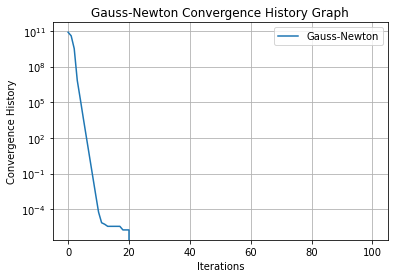

In [18]:
import matplotlib.pyplot as plt
plt.semilogy(np.abs(Fs_gn - Fs_gn[-1]), label="Gauss-Newton")

plt.xlabel("Iterations")
plt.ylabel("Convergence History")
plt.title("Gauss-Newton Convergence History Graph")
plt.legend()
plt.grid()

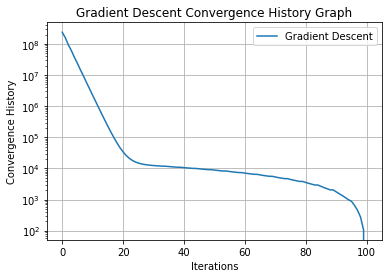

In [19]:
import matplotlib.pyplot as plt
plt.semilogy(np.abs(Fs_sd - Fs_sd[-1]), label="Gradient Descent")

plt.xlabel("Iterations")
plt.ylabel("Convergence History")
plt.title("Gradient Descent Convergence History Graph")
plt.legend()
plt.grid()

In [20]:
model(*theta_gn).astype(np.int32)

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      1,
            1,      2,      2,      3,      5,      6,      9,     12,
           16,     22,     29,     38,     51,     66,     87,    113,
          147,    189,    244,    312,    399,    507,    643,    811,
         1020,   1278,   1594,   1982,   2455,   3029,   3723,   4559,
         5562,   6760,   8185,   9873,  11864,  14203,  16940,  20128,
        23826,  28097,  33010,  38635,  45050,  52331,  60561,  69822,
        80196,  91766, 104609, 118802, 134413, 151504, 170125, 190318,
       212106, 235500, 260491, 287050, 315129, 344653, 375526, 407626,
       440806, 474895, 509696, 544991, 580539, 616081, 651340, 686028,
       719847, 752493, 783662, 813053, 840375, 865349, 887715, 907236,
       923699, 936925, 946767])

In [21]:
model(*theta_sd).astype(np.int32)

array([     6,      7,      9,     11,     14,     17,     22,     27,
           33,     40,     49,     60,     74,     90,    109,    132,
          159,    192,    231,    278,    333,    398,    476,    567,
          674,    799,    946,   1118,   1318,   1551,   1822,   2135,
         2498,   2915,   3396,   3948,   4581,   5304,   6128,   7067,
         8133,   9341,  10706,  12247,  13981,  15927,  18109,  20548,
        23267,  26294,  29655,  33377,  37491,  42027,  47016,  52491,
        58486,  65034,  72169,  79925,  88336,  97435, 107253, 117823,
       129174, 141331, 154321, 168164, 182879, 198480, 214977, 232376,
       250674, 269868, 289945, 310886, 332667, 355254, 378610, 402686,
       427428, 452774, 478655, 504994, 531705, 558700, 585879, 613140,
       640374, 667466, 694301, 720755, 746707, 772031, 796602, 820295,
       842988, 864559, 884891])

In [22]:
model(*init_theta).astype(np.int32)

array([     6,      8,     10,     13,     16,     20,     24,     30,
           37,     45,     55,     67,     81,     99,    120,    145,
          175,    210,    253,    303,    363,    433,    516,    613,
          728,    862,   1018,   1201,   1414,   1661,   1947,   2279,
         2661,   3101,   3606,   4186,   4848,   5605,   6467,   7446,
         8557,   9813,  11231,  12829,  14625,  16639,  18892,  21407,
        24209,  27323,  30776,  34596,  38813,  43456,  48557,  54149,
        60265,  66937,  74199,  82084,  90627,  99858, 109810, 120512,
       131993, 144279, 157394, 171358, 186187, 201896, 218493, 235981,
       254361, 273624, 293757, 314742, 336552, 359155, 382510, 406569,
       431279, 456576, 482391, 508647, 535261, 562142, 589193, 616313,
       643392, 670320, 696978, 723250, 749012, 774141, 798516, 822012,
       844508, 865887, 886033])

# Question 4

## Section A

In [23]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def logistic_regression(X, w):
    return sigmoid(X.transpose()@w)

def logistic_regression_loss(X, y):
    c1 = y
    c2 = 1-c1
    m = X.shape[1]
    
    sig = lambda w: logistic_regression(X, w)
    loss = lambda w: (-1/m)*(c1.transpose()@np.log(sig(w))+c2.transpose()@np.log(1-sig(w)))
    grad = lambda w: (1/m)*X@(sig(w)-c1)
    hess = lambda w: (1/m)*X@np.diag(sig(w)*(1-sig(w)))@X.transpose()
    
    return loss, grad, hess

## Section B

### Gradient testing

In [24]:
X = np.random.rand(10, 10)
y = np.rint(np.random.rand(10))
loss, grad, hess = logistic_regression_loss(X, y)
w = np.random.rand(10)
d = np.random.rand(10)
d = d/np.linalg.norm(d)

O1 = []
O2 = []
eps = 1
for k in range(10):
    eps /= 2
    O1.append(np.abs(loss(w+eps*d)-loss(w)))
    O2.append(np.abs(loss(w+eps*d)-loss(w)-eps*d@grad(w)))

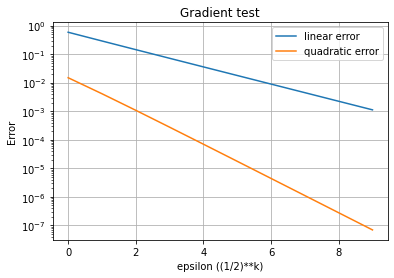

In [25]:
import matplotlib.pyplot as plt
plt.semilogy(O1, label="linear error")
plt.semilogy(O2, label="quadratic error")

plt.xlabel("epsilon ((1/2)**k)")
plt.ylabel("Error")
plt.title("Gradient test")
plt.legend()
plt.grid()

### Jacobian testing

In [26]:
X = np.random.rand(10, 10)
y = np.rint(np.random.rand(10))
loss, grad, hess = logistic_regression_loss(X, y)
w = np.random.rand(10)
d = np.random.rand(10)
d = d/np.linalg.norm(d)

O1 = []
O2 = []
eps = 1
for k in range(10):
    eps /= 2
    O1.append(np.linalg.norm(grad(w+eps*d)-grad(w)))
    O2.append(np.linalg.norm(grad(w+eps*d)-grad(w)-eps*hess(w)@d))

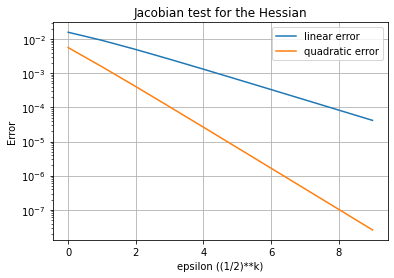

In [27]:
plt.semilogy(O1, label="linear error")
plt.semilogy(O2, label="quadratic error")

plt.xlabel("epsilon ((1/2)**k)")
plt.ylabel("Error")
plt.title("Jacobian test for the Hessian")
plt.legend()
plt.grid()

## Section C

In [28]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
from tqdm import tqdm
import numpy as np
import struct
from array import array
from os.path import join
import os
import random
import matplotlib.pyplot as plt

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            meanval = np.mean(img)
            stdval = np.std(img)
            img = (img - meanval) / (stdval + 0.1)
            images[i][:] = img
            
        return images, labels
            
    def load_data(self, digit_1, digit_2):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        
        x_train = np.asarray(x_train)
        y_train = np.asarray(y_train)
        x_test = np.asarray(x_test)
        y_test = np.asarray(y_test)
        
        x_train = x_train[(y_train == digit_1) | (y_train == digit_2)]
        x_train = x_train.reshape((x_train.shape[0], -1)).transpose()
        
        y_train = y_train[(y_train == digit_1) | (y_train == digit_2)]
        y_train[y_train == digit_1]=0
        y_train[y_train == digit_2]=1
        
        x_test = x_test[(y_test == digit_1) | (y_test == digit_2)]
        x_test = x_test.reshape((x_test.shape[0], -1)).transpose()
        
        y_test = y_test[(y_test == digit_1) | (y_test == digit_2)]
        y_test[y_test == digit_1]=0
        y_test[y_test == digit_2]=1
        
        return (x_train[:30000], y_train[:30000]),(x_test, y_test)  

In [29]:
#
# Verify Reading Dataset via MnistDataloader class
#
# Set file paths based on added MNIST Datasets
#
cwd = os.getcwd()
input_path = cwd + '\MNIST'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

In [30]:
# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1
    plt.show()

In [168]:
def linesearch(loss_fn, iterations, w, d, grad, alpha=1, beta=0.5, c=1e-4):
    for j in range(iterations):
        if loss_fn(w+alpha*d) <= loss_fn(w) + c*alpha*(d@grad):
            break
        else:
            alpha = alpha*beta
    return alpha

def opt(loss_fn, grad_fn, hessian_fn, loss_fn_test, iterations=100, method="sd", eps=1e-3):
    train_losses = [loss_fn(w_init)]
    test_losses = [loss_fn_test(w_init)]
    w_opt_test = w_init
    w = w_init
    
    for i in (prog_bar := tqdm(range(iterations))):
        grad = grad_fn(w)
        hessian = hessian_fn(w)
        if method == "newton":
            d = -(np.linalg.inv(hessian + 0.5*np.eye(hessian.shape[0]))@grad)
        elif method == "sd":
            d = -grad
        else:
            print("Unknown method")
            return
        alpha = linesearch(loss_fn, 10, w, d, grad)
        w = np.clip(w + alpha*d, -1, 1)
        train_losses.append(loss_fn(w))
        test_losses.append(loss_fn_test(w))
        
        if test_losses[-1] < loss_fn_test(w_opt_test):
            w_opt_test = w
        else:
            print('out')
            
        if np.linalg.norm(grad_fn(w))/np.linalg.norm(grad)<eps:
            break
        
    return (train_losses, w), (test_losses, w_opt_test)

In [175]:
sample_size = 28*28

w_init = np.random.rand(sample_size)

### Test for 0/1

In [176]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train_01, y_train_01), (x_test_01, y_test_01) = mnist_dataloader.load_data(0,1)

In [177]:
loss_fn_01, grad_fn_01, hess_fn_01 = logistic_regression_loss(x_train_01, y_train_01)
loss_fn_test_01, _, _ = logistic_regression_loss(x_test_01, y_test_01)

In [178]:
(train_losses_01, w_opt_train_01), (test_losses_01, w_opt_test_01) = opt(loss_fn_01, grad_fn_01, hess_fn_01, loss_fn_test_01, iterations=100, method='newton')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]<ipython-input-23-e353e64fceb4>:13: RuntimeWarning: divide by zero encountered in log
  loss = lambda w: (-1/m)*(c1.transpose()@np.log(sig(w))+c2.transpose()@np.log(1-sig(w)))
<ipython-input-23-e353e64fceb4>:13: RuntimeWarning: invalid value encountered in matmul
  loss = lambda w: (-1/m)*(c1.transpose()@np.log(sig(w))+c2.transpose()@np.log(1-sig(w)))
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:56<00:00,  2.37s/it]


In [179]:
conv_hist_train_01 = np.abs(train_losses_01 - loss_fn_01(w_opt_train_01))
conv_hist_test_01 = np.abs(test_losses_01 - loss_fn_test_01(w_opt_test_01))

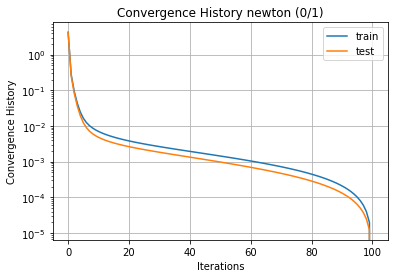

In [180]:
plt.semilogy(conv_hist_train_01, label="train")
plt.semilogy(conv_hist_test_01, label="test")

plt.xlabel("Iterations")
plt.ylabel("Convergence History")
plt.title("Convergence History newton (0/1)")
plt.legend()
plt.grid()

### Test for 8/9

In [169]:
sample_size = 28*28

w_init = np.random.rand(sample_size)

In [170]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train_89, y_train_89), (x_test_89, y_test_89) = mnist_dataloader.load_data(8,9)

In [171]:
loss_fn_89, grad_fn_89, hess_fn_89 = logistic_regression_loss(x_train_89, y_train_89)
loss_fn_test_89, _, _ = logistic_regression_loss(x_test_89, y_test_89)

In [172]:
(train_losses_89, w_opt_train_89), (test_losses_89, w_opt_test_89) = opt(loss_fn_89, grad_fn_89, hess_fn_89, loss_fn_test_89, iterations=100, method='newton')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]<ipython-input-23-e353e64fceb4>:13: RuntimeWarning: divide by zero encountered in log
  loss = lambda w: (-1/m)*(c1.transpose()@np.log(sig(w))+c2.transpose()@np.log(1-sig(w)))
<ipython-input-23-e353e64fceb4>:13: RuntimeWarning: invalid value encountered in matmul
  loss = lambda w: (-1/m)*(c1.transpose()@np.log(sig(w))+c2.transpose()@np.log(1-sig(w)))
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


In [173]:
conv_hist_train_89 = np.abs(train_losses_89 - loss_fn_89(w_opt_train_89))
conv_hist_test_89 = np.abs(test_losses_89 - loss_fn_test_89(w_opt_test_89))

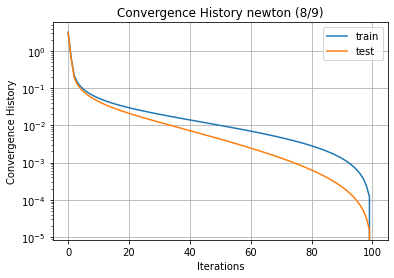

In [174]:
plt.semilogy(conv_hist_train_89, label="train")
plt.semilogy(conv_hist_test_89, label="test")

plt.xlabel("Iterations")
plt.ylabel("Convergence History")
plt.title("Convergence History newton (8/9)")
plt.legend()
plt.grid()

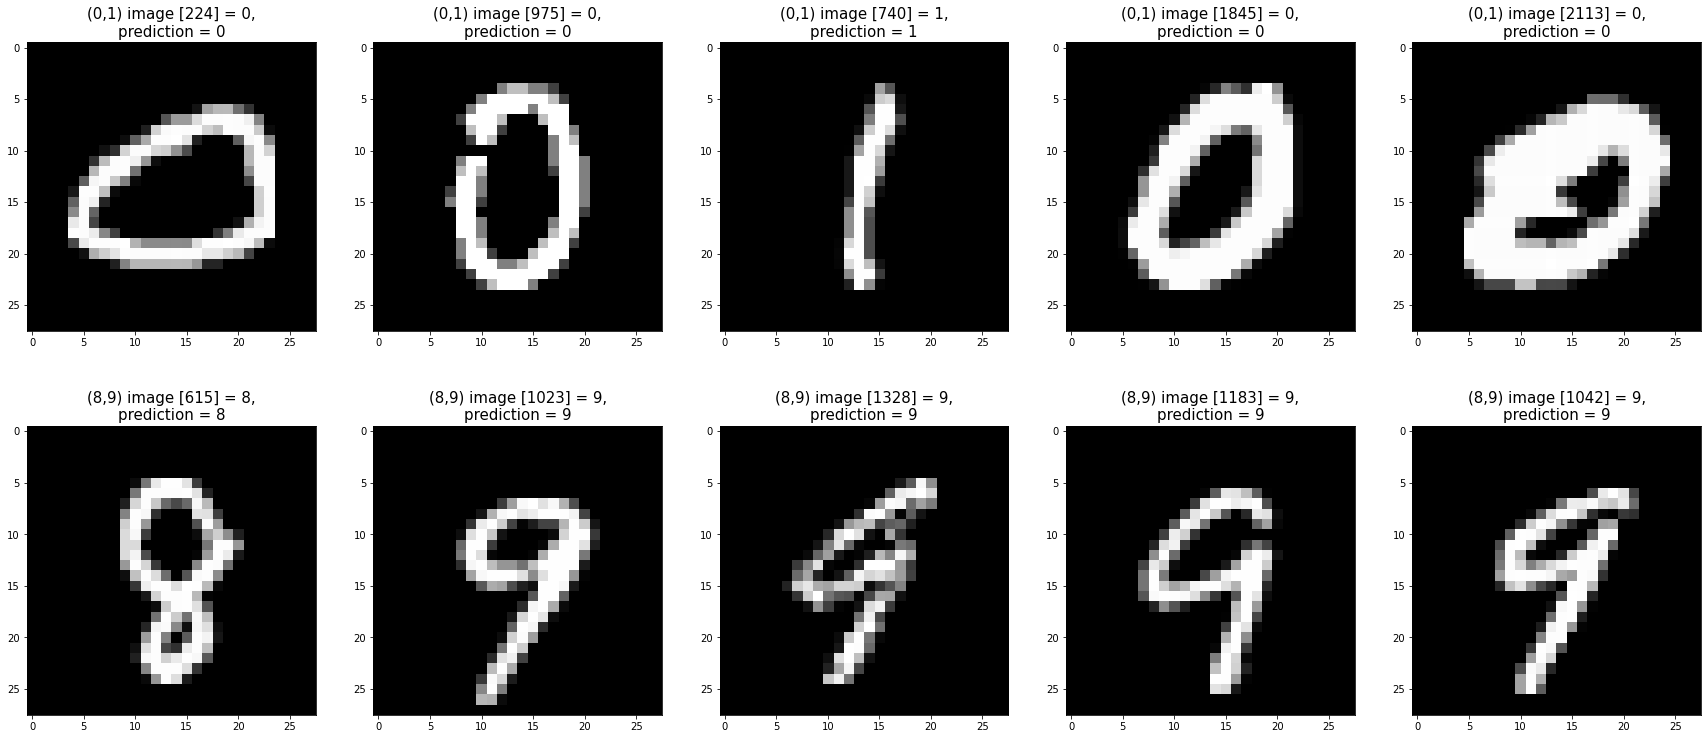

In [44]:
# Show some random training and test images 

images_2_show = []
titles_2_show = []
x_test_temp_01 = x_test_01.transpose().reshape(-1, 28, 28)
x_test_temp_89 = x_test_89.transpose().reshape(-1, 28, 28)

for i in range(0, 5):
    r = random.randint(0, x_test_temp_01.shape[0])
    images_2_show.append(x_test_temp_01[r])
    x_pred_01 = sigmoid(x_test_01.transpose()[r]@w_opt_train_01)
    titles_2_show.append(f'(0,1) image [{str(r)}] = {y_test_01[r]},\nprediction = {x_pred_01:.0f}')    

for i in range(0, 5):
    r = random.randint(0, x_test_temp_89.shape[0])
    images_2_show.append(x_test_temp_89[r])
    x_pred_89 = sigmoid(x_test_89.transpose()[r]@w_opt_train_89)
    titles_2_show.append(f'(8,9) image [{str(r)}] = {9 if y_test_89[r] else 8},\nprediction = {x_pred_89+8:.0f}')    

show_images(images_2_show, titles_2_show)